Processes the data file produced from the following ping script
>ping www.google.com -D -i 5 >> ping_tracker.txt

In [1]:
from ping_processing import Ping_Extractor

In [2]:
pe = Ping_Extractor()

In [3]:
pe.read_file(r'./ping_tracker.txt')

In [4]:
# Processing with 240 bin rolling mean (for 5 second pings --> 20 minute intervals)
pe.parse_data(rolling_interval=240)

### Plotting Time Difference (Raw and Rolling Ping Latency)

In [5]:
pe.data_processed

,timestamp,time_delta,latency,datetime,time_delta_rolling,latency_rolling
0,2021-12-29 04:57:05.772328,5.009649,33.3,2021-12-29 04:57:05.772328,5.005347,19.248333
1,2021-12-29 04:57:10.761133,4.988805,16.5,2021-12-29 04:57:10.761133,5.005347,19.248333
2,2021-12-29 04:57:15.766644,5.005511,16.2,2021-12-29 04:57:15.766644,5.005347,19.248333
3,2021-12-29 04:57:20.773165,5.006521,17.2,2021-12-29 04:57:20.773165,5.005347,19.248333
4,2021-12-29 04:57:25.778947,5.005782,17.5,2021-12-29 04:57:25.778947,5.005347,19.248333
...,...,...,...,...,...,...
33930,2021-12-31 04:07:55.350566,5.010874,18.5,2021-12-31 04:07:55.350566,5.005457,18.307500
33931,2021-12-31 04:08:00.349750,4.999184,11.9,2021-12-31 04:08:00.349750,5.005408,18.266667
33932,2021-12-31 04:08:05.360728,5.010978,17.7,2021-12-31 04:08:05.360728,5.005436,18.256667
33933,2021-12-31 04:08:10.366091,5.005363,17.1,2021-12-31 04:08:10.366091,5.005446,18.254583


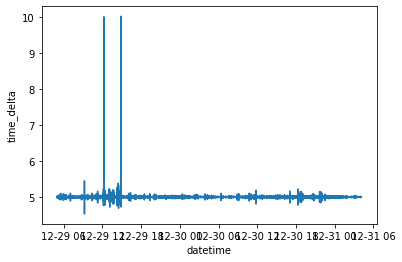

In [13]:
import seaborn as sns
y_var = 'time_delta'
sns.lineplot(data = pe.data_processed, x = 'datetime', y = y_var)

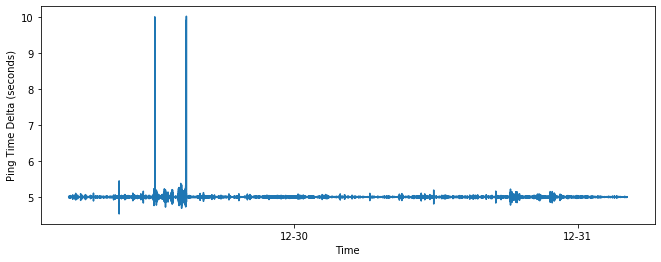

In [14]:
pe.plot_ping_timediff()

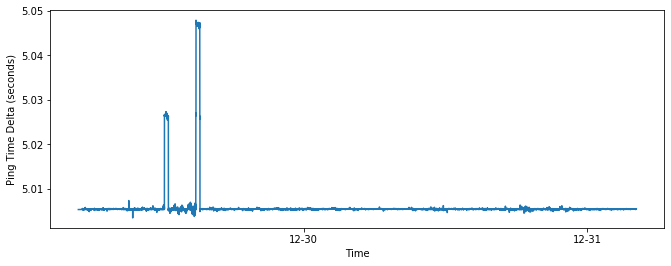

In [15]:
pe.plot_ping_timediff(rolling=True)

### Plotting Latency (Raw and Rolling Mean)

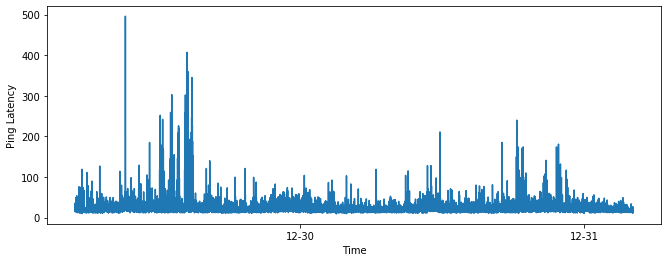

In [16]:
pe.plot_ping_latency()

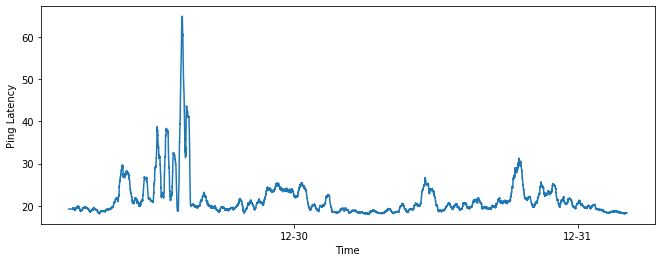

In [17]:
pe.plot_ping_latency(rolling=True)

The following script is a start toward collecting timestamped speed test data. 
Requires installation of speedtest on linux.

echo "##--##" >> speed_out.txt; curl icanhazepoch.com >> speed_out.txt ; speedtest | grep -f grepfilter >> speed_out.txt